In [1]:
%cd '../'

/home/rylov/PycharmProjects/multiclass-multiband-classification/src/experiments/exp_resnet


In [2]:
import os

from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support

import seaborn as sns
from matplotlib import pyplot as plt

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as f

from model import TorchLightNet
from generator import MyDataset
from data_frame import make_data_frame
from settings import CSV_FOLDER_PATH, CHECK_POINTER_PATH, SUB_EXP, class_names

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1           [-1, 13, 70, 70]               0
            Conv2d-2           [-1, 64, 32, 32]          40,832
       BatchNorm2d-3           [-1, 64, 32, 32]             128
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 15, 15]               0
            Conv2d-6           [-1, 64, 15, 15]           4,160
       BatchNorm2d-7           [-1, 64, 15, 15]             128
              ReLU-8           [-1, 64, 15, 15]               0
            Conv2d-9           [-1, 64, 15, 15]          36,928
      BatchNorm2d-10           [-1, 64, 15, 15]             128
             ReLU-11           [-1, 64, 15, 15]               0
           Conv2d-12          [-1, 256, 15, 15]          16,640
      BatchNorm2d-13          [-1, 256, 15, 15]             512
           Conv2d-14          [-1, 256,

In [3]:
device = torch.device(f'cuda:0')

dataset, df = make_data_frame(CSV_FOLDER_PATH, 'train.csv', 'val.csv', 'test.csv')
test_df = df.get('test')

test_dataset = MyDataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=len(test_df), pin_memory=True, shuffle=False)

In [4]:
chk_path = os.path.join(CHECK_POINTER_PATH, SUB_EXP, 'epoch=71-val_loss=0.5181-val_acc=0.8353.ckpt')
model = TorchLightNet.load_from_checkpoint(checkpoint_path=chk_path)
model.to(device)
model.eval()

test_predictions = []
labels_list = []
idx, inputs, labels = next(iter(test_loader))
bands_13 = inputs.to(device, dtype=torch.float)
labels = labels.data.cpu().numpy()
with torch.set_grad_enabled(False):
    preds_logits = model(bands_13)
    preds_logits = preds_logits.data.cpu()
    preds_class = torch.argmax(preds_logits, dim=1).numpy()
test_predictions.append(preds_class)
labels_list.append(labels)
    
test_predictions = np.concatenate(test_predictions)
labels_list = np.concatenate(labels_list)

In [5]:
precision, recall, f1, _ = precision_recall_fscore_support(labels_list,
                                                           test_predictions,
                                                           average='macro'  # cause we have balanced classes
                                                          )
print(f'precision is {round(precision, 2)}, recall is {round(recall, 2)}, f1 is {round(f1, 2)}')

precision is 0.81, recall is 0.8, f1 is 0.8


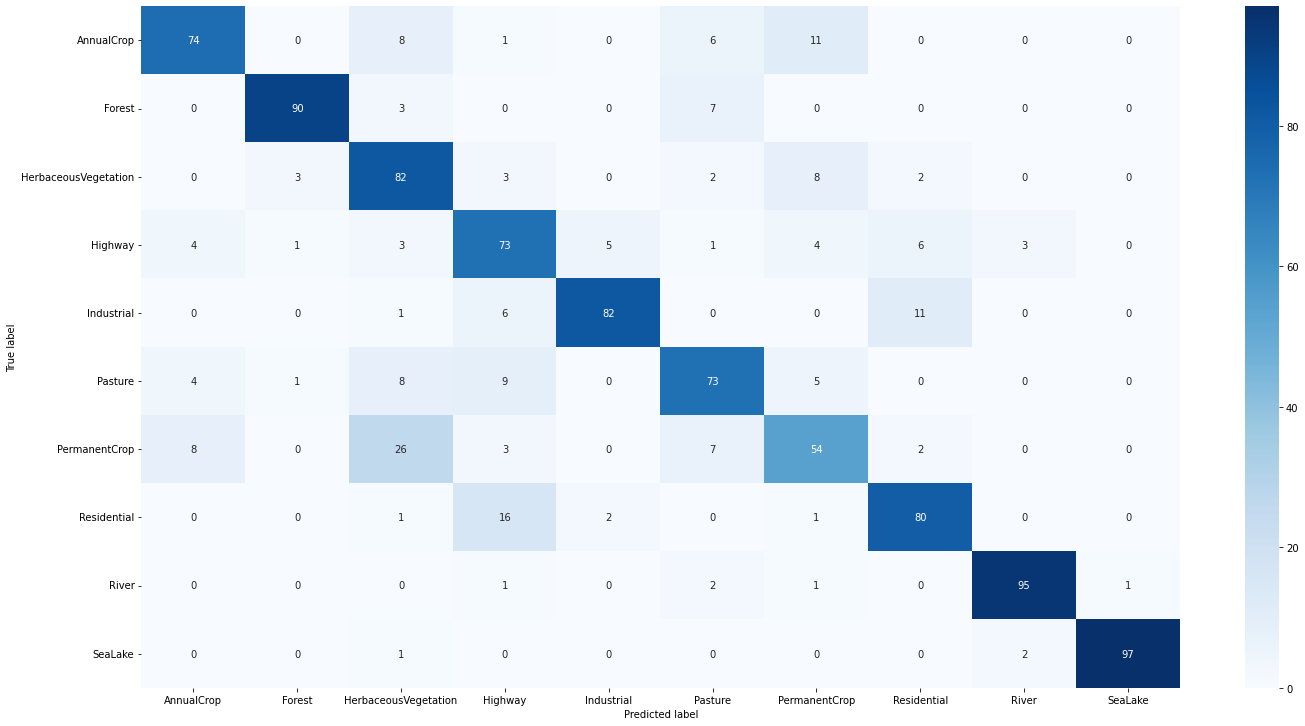

In [6]:
conf_matrix = metrics.confusion_matrix(labels_list, test_predictions) 
conf_matrix_df = pd.DataFrame(conf_matrix,
                              index=class_names,
                              columns=class_names)

plt.figure(figsize=(20, 10))
sns.heatmap(conf_matrix_df,
            annot=True,
            fmt='d',
            cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()